## QSAR Challenge

In [29]:
## Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator


In [2]:
## Load Dataset
data = pd.read_csv('resources/data_train.csv', index_col=0).reset_index(drop=True)
data.head()

## Data Preprocessing 
data['mol'] = [Chem.MolFromSmiles(smi) for smi in tqdm(data['smiles'], desc='Convert Smiles to Mol')]


#Convert the molecules to Morgan fingerprints
mfpgen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fps = np.array([mfpgen.GetFingerprintAsNumPy(mol) for mol in tqdm(data.mol, desc='Gen Morgen Fingerprints')])
fps


Convert Smiles to Mol:   0%|          | 0/12000 [00:00<?, ?it/s]

[12:55:06] WARNING: not removing hydrogen atom without neighbors
[12:55:06] WARNING: not removing hydrogen atom without neighbors
[12:55:07] WARNING: not removing hydrogen atom without neighbors
[12:55:07] WARNING: not removing hydrogen atom without neighbors


Gen Morgen Fingerprints:   0%|          | 0/12000 [00:00<?, ?it/s]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [19]:
## Split the data
# Separate features (fingerprints) and targets
X = fps  # fingerprints we generated earlier
Y = data[data.columns[1:-1]].values  # all columns except smiles and mol
Y

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f'Train shape X: {X_train.shape}')
print(f'Test shape X: {X_test.shape}')
print(f'Train shape Y: {Y_train.shape}')
print(f'Test shape Y: {Y_test.shape}')

Train shape X: (9600, 1024)
Test shape X: (2400, 1024)
Train shape Y: (9600, 11)
Test shape Y: (2400, 11)


In [31]:
## The model for the tasks
SEED = 42

def training_for_task(X_train, Y_train):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=SEED), params, cv=skf, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    return grid_search.best_estimator_, grid_search.best_score_


def train_rf(X_train, X_test, Y_train, Y_test):
    n_tasks = Y_train.shape[1]
    y_hats_probability = np.empty((X_test.shape[0], n_tasks))
    y_hats_class = np.empty_like(y_hats_probability)

    #Train a random forest for each task
    for i in tqdm(range(n_tasks), desc=f'Training for task:'):

        #andom_forest = RandomForestClassifier(n_estimators=100, random_state=seed)
        index = ~np.isnan(Y_train[:, i]) & (Y_train[:, i] != 0) # Mask out unknown values
        

        random_forest, roc_auc = training_for_task(X_train[index], Y_train[index, i])
        y_hats_probability[:, i] = random_forest.predict_proba(X_test)[:, 1]
        y_hats_class[:, i] = random_forest.predict(X_test)
    return y_hats_probability, y_hats_class

#Train the model
y_hat_probability, y_hat_class = train_rf(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)


Training for task::   0%|          | 0/11 [00:00<?, ?it/s]

In [32]:
pd.DataFrame(y_hat_probability)

,0,1,2,3,4,5,6,7,8,9,10
0,0.023167,0.473802,0.86,0.645591,0.669209,0.03,0.107548,0.175833,0.396106,0.027005,0.002198
1,0.074429,0.631085,0.92,0.854746,0.299852,0.00,0.021667,0.080000,0.183960,0.091154,0.001540
2,0.000000,0.389074,0.96,0.645454,0.370169,0.00,0.009286,0.025000,0.133362,0.034410,0.002751
3,0.227108,0.520173,0.72,0.727048,0.287696,0.23,0.089690,0.438333,0.393063,0.186133,0.033525
4,0.135536,0.632166,0.72,0.688993,0.289802,0.12,0.062913,0.406667,0.293773,0.132389,0.025002
...,...,...,...,...,...,...,...,...,...,...,...
2395,0.048175,0.387995,0.80,0.801584,0.125152,0.13,0.019167,0.200000,0.178687,0.046318,0.002306
2396,0.039583,0.443458,0.98,0.629757,0.060845,0.00,0.061984,0.045000,0.146062,0.063342,0.001269
2397,0.005873,0.311221,0.66,0.611217,0.144011,0.03,0.037429,0.175000,0.269910,0.129650,0.001773
2398,0.063548,0.606341,0.72,0.663548,0.293683,0.09,0.009000,0.140000,0.422686,0.104262,0.002476


In [33]:
# binary predictions
pd.DataFrame(y_hat_class)

,0,1,2,3,4,5,6,7,8,9,10
0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
2395,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2396,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2397,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2398,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Model Evaluation

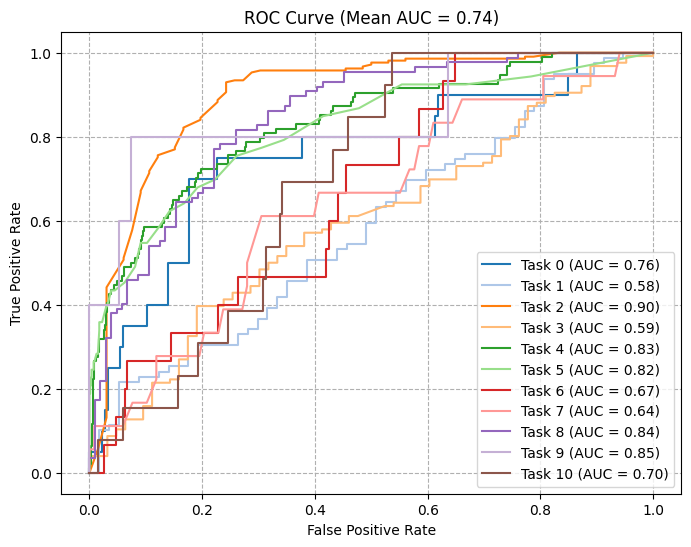

In [34]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

sns.set_palette('tab20', plt.cm.tab20.N)

def plot_roc(target, prediction):
    fig, ax = plt.subplots(figsize=(8, 6))
    aucs = []
    for i in range(target.shape[1]):
        y_prediction = prediction[:, i]
        y_target = target[:, i]
        idx = ~np.isnan(y_target) & (y_target != 0) # Mask out unknown values
        fpr, tpr, thresholds = roc_curve(y_target[idx], y_prediction[idx])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, label=f'Task {i} (AUC = {roc_auc:.2f})')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve (Mean AUC = {:.2f})'.format(np.mean(aucs)))
    ax.legend()
    ax.grid(linestyle='--')
    plt.show()

plot_roc(Y_test, y_hat_probability)